In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from icecream import ic

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [189]:
# initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
num_epochs = 20
batch_size = 5
learning_rate = 1e-2
output_size = 1  # num_classes

# RNN parameters
input_size = 1
hidden_size = 3
n_layers = 1
seq_length = 10

In [190]:
# read data
sale = pd.read_csv('../../data/Time series data/sale.csv', index_col=0)

In [191]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15052 entries, 0 to 15051
Data columns (total 52 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   week_1   15052 non-null  float64
 1   week_2   15052 non-null  float64
 2   week_3   15052 non-null  float64
 3   week_4   15052 non-null  float64
 4   week_5   15052 non-null  float64
 5   week_6   15052 non-null  float64
 6   week_7   15052 non-null  float64
 7   week_8   15052 non-null  float64
 8   week_9   15052 non-null  float64
 9   week_10  15052 non-null  float64
 10  week_11  15052 non-null  float64
 11  week_12  15052 non-null  float64
 12  week_13  15052 non-null  float64
 13  week_14  15052 non-null  float64
 14  week_15  15052 non-null  float64
 15  week_16  15052 non-null  float64
 16  week_17  15052 non-null  float64
 17  week_18  15052 non-null  float64
 18  week_19  15052 non-null  float64
 19  week_20  15052 non-null  float64
 20  week_21  15052 non-null  float64
 21  week_22  150

In [192]:
sale

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,2.291574,2.882838,3.581805,4.013875,1.109924,2.834247,2.625045,2.196884,4.208887,2.969051,...,1.242250,2.771072,3.778143,3.161634,3.792645,2.015481,2.826184,2.520788,2.637210,2.748923
1,0.609664,2.523604,2.609537,3.695997,3.399272,2.616612,1.651935,1.348295,3.862523,2.061477,...,2.477505,2.284513,3.461783,3.101052,3.442420,1.915776,2.426168,1.662855,2.481925,2.411202
2,3.422793,1.812651,-0.097966,1.724064,3.093660,1.781278,2.849946,2.949707,3.560835,2.813926,...,2.219667,2.359834,1.932029,2.731947,1.836245,1.219933,1.222740,1.720052,2.169939,2.161702
3,3.372283,2.577254,3.854308,3.449679,2.517676,2.635679,2.352706,2.856216,1.948434,1.484706,...,1.670912,0.909113,3.216652,1.775346,3.270484,2.399709,3.032071,1.703666,1.750585,1.821736
4,2.997727,1.799415,3.648090,2.391567,2.376778,1.864717,0.408062,2.346726,3.260303,2.645002,...,2.304058,3.038905,2.038733,2.825186,2.232937,2.509050,2.881796,-1.712131,2.140366,1.926818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15047,1.952726,1.547637,1.902789,0.813261,2.600979,2.910638,2.878396,0.594216,3.526187,3.275296,...,0.486073,3.336252,3.307270,3.026835,1.472116,3.220792,2.664044,1.546153,3.026948,2.611774
15048,0.652824,3.589191,3.257707,2.821276,2.185937,2.534801,-0.774375,3.835695,3.776809,3.502364,...,2.684153,1.384912,3.184570,2.832941,2.092033,2.606198,0.753193,3.160599,3.085800,2.814394
15049,3.833707,3.548071,3.194160,1.993437,3.013547,1.825047,2.305196,0.522475,3.126647,3.231283,...,2.928937,1.633754,3.078598,2.466563,0.489380,3.518725,3.406466,3.031342,1.852089,3.005631
15050,3.186439,1.703232,3.196591,2.407803,-0.474370,3.879943,3.762408,3.415669,1.790529,3.280106,...,1.642612,2.387770,2.149893,0.688463,3.150805,3.242209,2.972728,1.196053,3.340991,2.921557


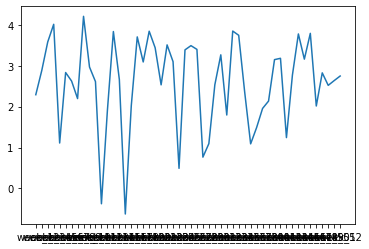

In [193]:
plt.plot(sale.iloc[0])

In [194]:
data_loader = DataLoader(sale.values, batch_size=batch_size, shuffle=True, drop_last=True)

In [195]:
next(iter(data_loader))

tensor([[ 1.7473,  2.7223,  2.0978,  0.7056,  3.2263,  3.2945,  2.9772,  1.4316,
          3.2263,  2.7148,  1.7409,  2.8999,  2.2957, -1.0082,  3.9758,  3.8967,
          3.5740,  1.6777,  3.4147,  2.4560,  0.2874,  3.6669,  3.5240,  3.1293,
          1.9298,  3.0273,  1.9955,  1.9656,  2.0877,  0.4602,  3.1420,  3.3180,
          3.1099,  0.5742,  3.6638,  3.2930,  2.8535,  2.2229,  2.5310, -2.2358,
          4.2220,  4.0979,  3.8261,  1.5960,  3.5543,  2.5227, -0.2537,  3.8847,
          3.7048,  3.3294,  1.9283,  3.1561],
        [ 1.8218,  2.6657,  2.2675, -1.0443,  3.9490,  3.8983,  3.5876,  1.6028,
          3.4540,  2.5410, -1.6804,  4.2360,  4.0296,  3.7054,  1.8431,  3.3984,
          2.2218,  1.7743,  2.7283,  2.3788,  0.6331,  3.3457,  3.3028,  2.9657,
          1.6673,  3.0763,  2.4185, -0.3714,  3.8306,  3.7253,  3.3841,  1.7613,
          3.2773,  2.3430,  0.9573,  3.3098,  3.1998,  2.7572,  1.9952,  2.6763,
          1.4897,  2.5260,  1.8789,  0.6446,  3.1365,  3.3216, 

In [196]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.hidden_layers = num_layers
        self.batch_size = batch_size

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)


    def forward(self, x, _hidden=None):
        if not _hidden:
            _hidden = self.init_hidden()
        _output, _hidden = self.rnn(x, _hidden)
        _output = self.out(_output)
        return _output

    def init_hidden(self):
        hidden = torch.zeros(self.hidden_layers, self.batch_size, self.hidden_size, dtype=torch.float)
        return hidden

In [197]:
model = RNN(input_size, hidden_size, n_layers, batch_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Training Epoch: 1/20 [0/3010]	Loss: 7.4820	LR: 0.0100


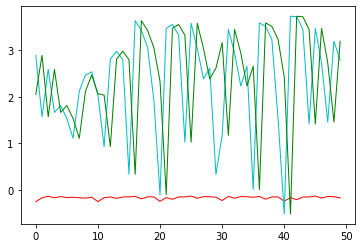

Training Epoch: 2/20 [0/3010]	Loss: 0.7050	LR: 0.0100


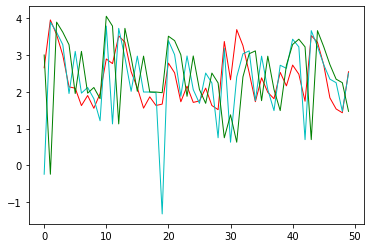

Training Epoch: 3/20 [0/3010]	Loss: 0.5038	LR: 0.0100


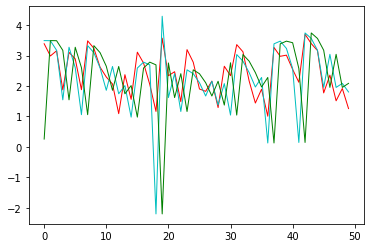

Training Epoch: 4/20 [0/3010]	Loss: 1.1854	LR: 0.0100


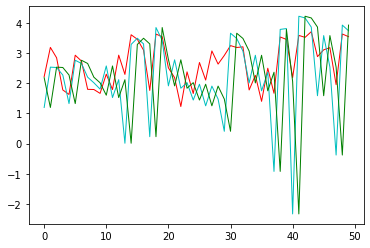

Training Epoch: 5/20 [0/3010]	Loss: 0.6031	LR: 0.0100


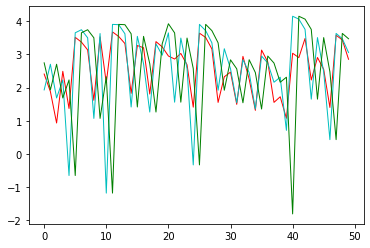

Training Epoch: 6/20 [0/3010]	Loss: 0.8729	LR: 0.0100


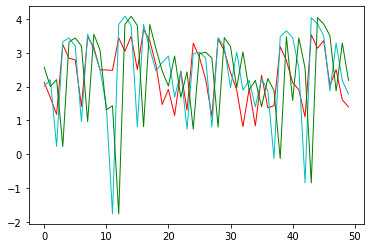

Training Epoch: 7/20 [0/3010]	Loss: 0.2898	LR: 0.0100


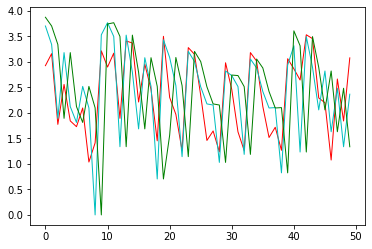

Training Epoch: 8/20 [0/3010]	Loss: 0.8123	LR: 0.0100


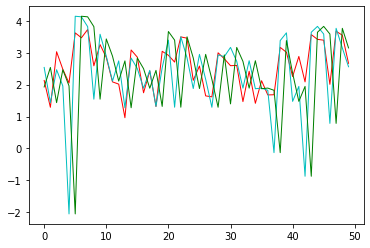

Training Epoch: 9/20 [0/3010]	Loss: 0.5894	LR: 0.0100


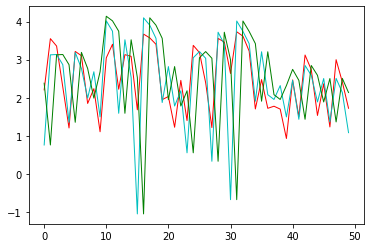

Training Epoch: 10/20 [0/3010]	Loss: 0.2793	LR: 0.0100


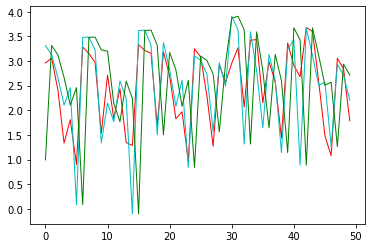

Training Epoch: 11/20 [0/3010]	Loss: 0.6872	LR: 0.0100


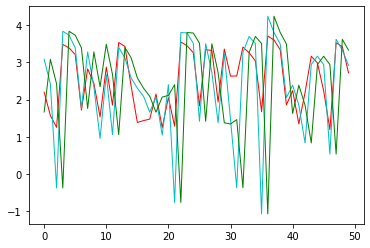

Training Epoch: 12/20 [0/3010]	Loss: 0.2667	LR: 0.0100


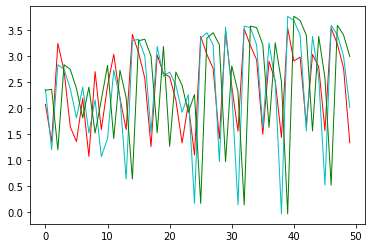

Training Epoch: 13/20 [0/3010]	Loss: 0.3034	LR: 0.0100


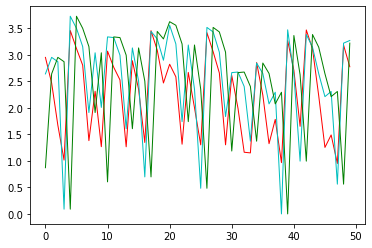

Training Epoch: 14/20 [0/3010]	Loss: 0.9142	LR: 0.0100


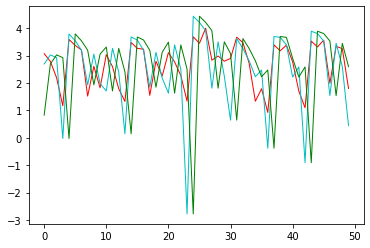

Training Epoch: 15/20 [0/3010]	Loss: 0.4490	LR: 0.0100


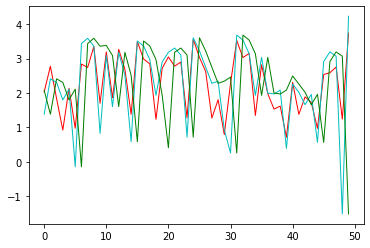

Training Epoch: 16/20 [0/3010]	Loss: 0.6269	LR: 0.0100


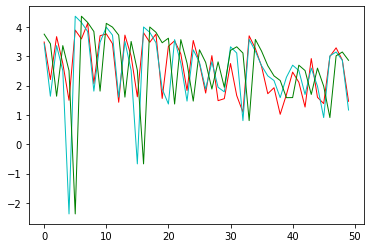

Training Epoch: 17/20 [0/3010]	Loss: 0.2452	LR: 0.0100


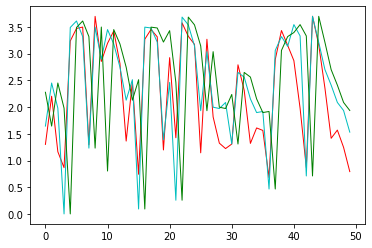

Training Epoch: 18/20 [0/3010]	Loss: 0.3864	LR: 0.0100


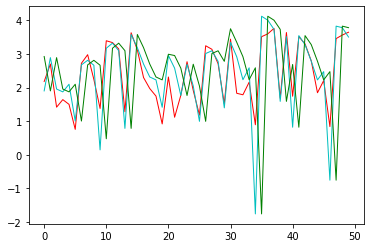

Training Epoch: 19/20 [0/3010]	Loss: 0.2746	LR: 0.0100


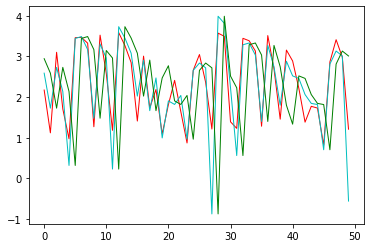

Training Epoch: 20/20 [0/3010]	Loss: 0.1202	LR: 0.0100


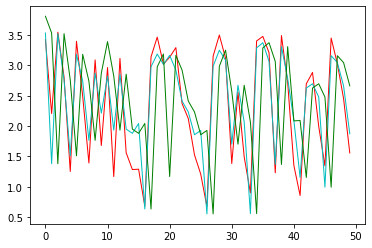

In [198]:
# train
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader):
        random_index = random.randint(0, data.shape[-1] - seq_length - 1)
        train_x = data[:, random_index: random_index+seq_length].unsqueeze(2).float()
        train_y = data[:, random_index + 1: random_index + seq_length + 1].unsqueeze(2).float()
        outputs = model(train_x.float())
        loss = criterion(outputs, train_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i == 0:
            print(f'Training Epoch: {epoch + 1}/{num_epochs} [{i}/{len(data_loader)}]\tLoss: {loss.item():0.4f}\tLR: {learning_rate:0.4f}')

            plt.plot(torch.flatten(outputs.detach()),'r-',linewidth=1,label='Output')
            plt.plot(torch.flatten(train_y),'c-',linewidth=1,label='Label')
            plt.plot(torch.flatten(train_x),'g-',linewidth=1,label='Input')
            plt.pause(0.1)